# ZINC Molecular Benchmark Dataset Preparation

This notebook demonstrates the **ZINC-12k molecular graph regression benchmark** dataset (Dwivedi et al., JMLR 2023).

**What this artifact does:**
- Loads and explores the ZINC-12k molecular graph dataset with the canonical 10k/1k/1k train/val/test split
- Each example contains a molecular graph (edge_index in COO format, integer atom-type node features 0–20, integer bond-type edge attributes 1–3, 9–37 nodes avg 23.2)
- The regression target is the penalized logP value
- We parse, validate, and visualize the dataset statistics

In [1]:
# --- Install dependencies ---
import importlib, subprocess, sys

def _install_if_missing(package, pip_name=None):
    """Install package if not already available."""
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or package])

_install_if_missing("matplotlib")

# Colab-specific: pin numpy for compatibility
_IN_COLAB = "google.colab" in sys.modules
if _IN_COLAB:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "numpy==1.26.4"])

print("Dependencies ready.")

Dependencies ready.


In [2]:
# --- Imports ---
import json
import os
import statistics
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 100

In [3]:
# --- Data loading helper ---
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/dataset_iter1_zinc_molecular/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded dataset with {len(data['datasets'])} dataset(s)")
print(f"Dataset name: {data['datasets'][0]['dataset']}")
print(f"Number of examples: {len(data['datasets'][0]['examples'])}")

Loaded dataset with 1 dataset(s)
Dataset name: ZINC-12k
Number of examples: 30


In [5]:
# --- Configuration ---
# Number of graphs to check for undirected edges
UNDIRECTED_CHECK_COUNT = 30  # original: 100 (full dataset uses 100)

# Number of examples to process for statistics
MAX_EXAMPLES = 30  # original: 12000 (full dataset has 12000)

## Explore Data Structure

Each example contains:
- **input**: JSON-stringified graph with `edge_index` (COO format), `node_feat` (atom types), `edge_attr` (bond types), `num_nodes`
- **output**: Penalized logP regression target (as string)
- **metadata**: fold (train/val/test), task_type, row_index, num_nodes, num_edges

In [6]:
# Show structure of first example
examples = data["datasets"][0]["examples"][:MAX_EXAMPLES]
ex0 = examples[0]

print("Example keys:", list(ex0.keys()))
print(f"\noutput (regression target): {ex0['output']}")
print(f"metadata_fold: {ex0['metadata_fold']}")
print(f"metadata_task_type: {ex0['metadata_task_type']}")
print(f"metadata_row_index: {ex0['metadata_row_index']}")
print(f"metadata_num_nodes: {ex0['metadata_num_nodes']}")
print(f"metadata_num_edges: {ex0['metadata_num_edges']}")

# Parse the input JSON string
inp = json.loads(ex0["input"])
print(f"\nParsed input keys: {list(inp.keys())}")
print(f"  num_nodes: {inp['num_nodes']}")
print(f"  node_feat (first 10): {inp['node_feat'][:10]}")
print(f"  edge_attr (first 10): {inp['edge_attr'][:10]}")
print(f"  edge_index shape: [{len(inp['edge_index'][0])}] x 2 (COO format)")

Example keys: ['input', 'output', 'metadata_fold', 'metadata_task_type', 'metadata_row_index', 'metadata_num_nodes', 'metadata_num_edges']

output (regression target): -0.20893476903438568
metadata_fold: train
metadata_task_type: regression
metadata_row_index: 137807
metadata_num_nodes: 9
metadata_num_edges: 16

Parsed input keys: ['edge_index', 'node_feat', 'edge_attr', 'num_nodes']
  num_nodes: 9
  node_feat (first 10): [0, 0, 1, 0, 1, 4, 6, 0, 0]
  edge_attr (first 10): [1, 1, 1, 1, 1, 1, 2, 1, 2, 1]
  edge_index shape: [16] x 2 (COO format)


## Parse and Analyze Graph Statistics

Extract statistics from all examples: node/edge counts, feature distributions, regression targets.

In [7]:
# Collect statistics across all examples (mirrors validate_examples from data.py)
all_node_feats = []
all_edge_attrs = []
all_num_nodes = []
all_num_edges = []
all_y = []

split_counts = Counter(ex["metadata_fold"] for ex in examples)

for ex in examples:
    inp = json.loads(ex["input"])
    all_node_feats.extend(inp["node_feat"])
    all_edge_attrs.extend(inp["edge_attr"])
    all_num_nodes.append(inp["num_nodes"])
    all_num_edges.append(len(inp["edge_attr"]))
    all_y.append(float(ex["output"]))

print(f"Split counts: {dict(split_counts)}")
print(f"Node features unique: {sorted(set(all_node_feats))}")
print(f"Edge attr unique: {sorted(set(all_edge_attrs))}")
print(f"Num nodes: min={min(all_num_nodes)}, max={max(all_num_nodes)}, avg={statistics.mean(all_num_nodes):.1f}")
print(f"Num edges: min={min(all_num_edges)}, max={max(all_num_edges)}, avg={statistics.mean(all_num_edges):.1f}")
print(f"Target y: min={min(all_y):.3f}, max={max(all_y):.3f}, mean={statistics.mean(all_y):.3f}, std={statistics.stdev(all_y):.3f}")

Split counts: {'train': 10, 'val': 10, 'test': 10}
Node features unique: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]
Edge attr unique: [1, 2, 3]
Num nodes: min=9, max=29, avg=21.7
Num edges: min=16, max=64, avg=45.8
Target y: min=-7.661, max=2.930, mean=-0.559, std=2.253


## Validate Examples

Check structural integrity: node feature ranges, edge attribute ranges, edge_index consistency, and undirected graph property.

In [8]:
# Validate examples (adapted from validate_examples in data.py)
errors = []

for i, ex in enumerate(examples):
    inp = json.loads(ex["input"])

    # Validate node features in [0, 27]
    for nf in inp["node_feat"]:
        if not (0 <= nf <= 27):
            errors.append(f"Example {i}: node_feat {nf} not in [0, 27]")

    # Validate edge attributes in [1, 3]
    for ea in inp["edge_attr"]:
        if not (1 <= ea <= 3):
            errors.append(f"Example {i}: edge_attr {ea} not in [1, 3]")

    # Validate edge_index consistency
    src = inp["edge_index"][0]
    dst = inp["edge_index"][1]
    if len(src) != len(dst):
        errors.append(f"Example {i}: edge_index lengths mismatch {len(src)} != {len(dst)}")
    if len(src) != len(inp["edge_attr"]):
        errors.append(f"Example {i}: edge count {len(src)} != edge_attr count {len(inp['edge_attr'])}")

# Undirected check on first UNDIRECTED_CHECK_COUNT graphs
undirected_ok = 0
undirected_fail = 0
for ex in examples[:UNDIRECTED_CHECK_COUNT]:
    inp = json.loads(ex["input"])
    edges = set(zip(inp["edge_index"][0], inp["edge_index"][1]))
    for u, v in list(edges):
        if (v, u) in edges:
            undirected_ok += 1
        else:
            undirected_fail += 1

print(f"Undirected check ({min(UNDIRECTED_CHECK_COUNT, len(examples))} graphs): {undirected_ok} bidirectional, {undirected_fail} unidirectional")

if errors:
    for e in errors[:20]:
        print(f"ERROR: {e}")
    print(f"Total errors: {len(errors)}")
else:
    print("Validation PASSED - all examples are structurally valid")

Undirected check (30 graphs): 1374 bidirectional, 0 unidirectional
Validation PASSED - all examples are structurally valid


## Results Summary & Visualization

Display a summary table of dataset statistics and visualize the distribution of graph sizes, regression targets, and feature types.

ZINC-12k Dataset Summary
Metric                                             Value
------------------------------------------------------------
Total examples                                        30
  test examples                                       10
  train examples                                      10
  val examples                                        10
Unique node features                                  13
Node feat range                                  [0, 13]
Unique edge attributes                                 3
Edge attr range                                   [1, 3]
Avg nodes per graph                                 21.7
Avg edges per graph                                 45.8
Target mean                                       -0.559
Target std                                         2.253
Validation errors                                      0


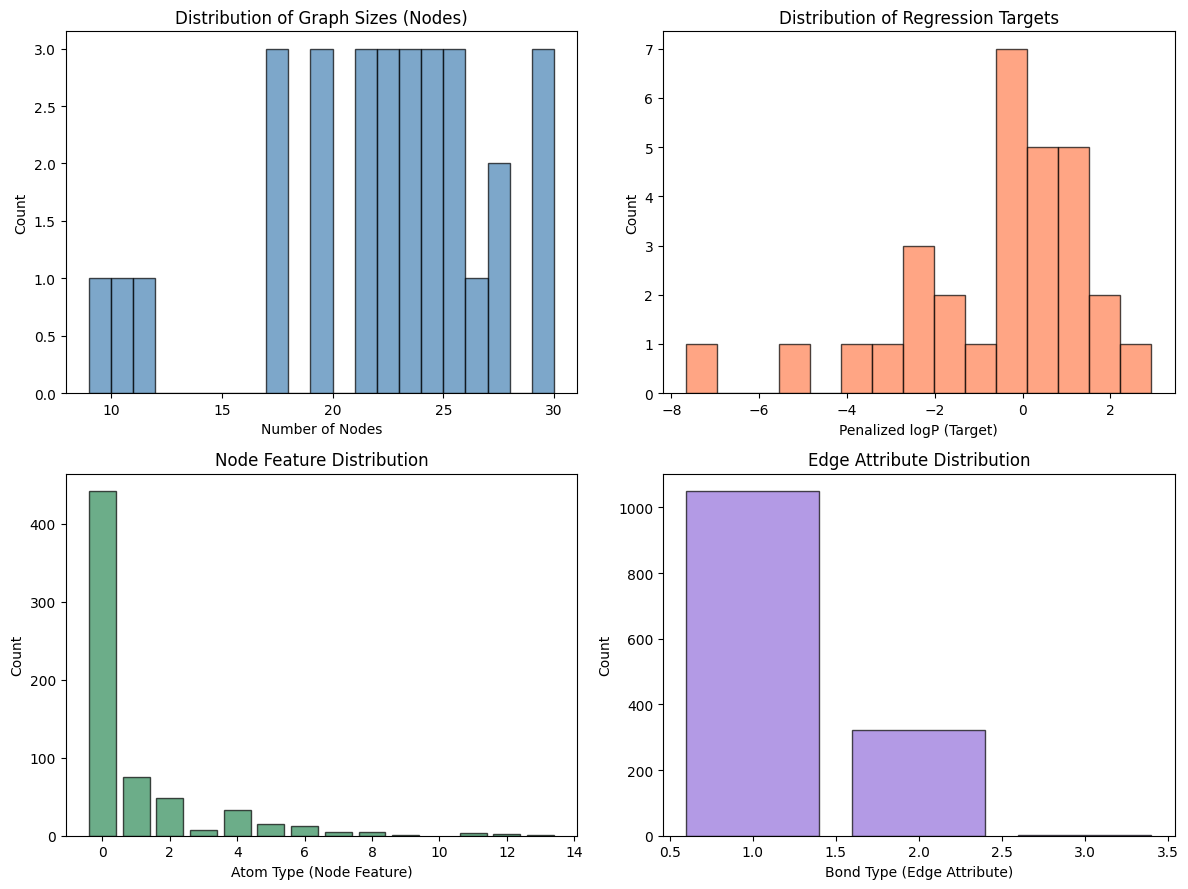

Saved visualization to zinc_dataset_stats.png


In [9]:
# --- Results summary table ---
print("=" * 60)
print("ZINC-12k Dataset Summary")
print("=" * 60)
print(f"{'Metric':<30} {'Value':>25}")
print("-" * 60)
print(f"{'Total examples':<30} {len(examples):>25}")
for fold, count in sorted(split_counts.items()):
    print(f"{'  ' + fold + ' examples':<30} {count:>25}")
print(f"{'Unique node features':<30} {len(set(all_node_feats)):>25}")
print(f"{'Node feat range':<30} {'[' + str(min(all_node_feats)) + ', ' + str(max(all_node_feats)) + ']':>25}")
print(f"{'Unique edge attributes':<30} {len(set(all_edge_attrs)):>25}")
print(f"{'Edge attr range':<30} {'[' + str(min(all_edge_attrs)) + ', ' + str(max(all_edge_attrs)) + ']':>25}")
print(f"{'Avg nodes per graph':<30} {statistics.mean(all_num_nodes):>25.1f}")
print(f"{'Avg edges per graph':<30} {statistics.mean(all_num_edges):>25.1f}")
print(f"{'Target mean':<30} {statistics.mean(all_y):>25.3f}")
print(f"{'Target std':<30} {statistics.stdev(all_y):>25.3f}")
print(f"{'Validation errors':<30} {len(errors):>25}")
print("=" * 60)

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# 1. Distribution of number of nodes
axes[0, 0].hist(all_num_nodes, bins=range(min(all_num_nodes), max(all_num_nodes) + 2),
                edgecolor="black", alpha=0.7, color="steelblue")
axes[0, 0].set_xlabel("Number of Nodes")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Distribution of Graph Sizes (Nodes)")

# 2. Distribution of regression targets
axes[0, 1].hist(all_y, bins=15, edgecolor="black", alpha=0.7, color="coral")
axes[0, 1].set_xlabel("Penalized logP (Target)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Distribution of Regression Targets")

# 3. Node feature distribution
nf_counts = Counter(all_node_feats)
nf_types = sorted(nf_counts.keys())
nf_vals = [nf_counts[t] for t in nf_types]
axes[1, 0].bar(nf_types, nf_vals, edgecolor="black", alpha=0.7, color="seagreen")
axes[1, 0].set_xlabel("Atom Type (Node Feature)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_title("Node Feature Distribution")

# 4. Edge attribute distribution
ea_counts = Counter(all_edge_attrs)
ea_types = sorted(ea_counts.keys())
ea_vals = [ea_counts[t] for t in ea_types]
axes[1, 1].bar(ea_types, ea_vals, edgecolor="black", alpha=0.7, color="mediumpurple")
axes[1, 1].set_xlabel("Bond Type (Edge Attribute)")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("Edge Attribute Distribution")

plt.tight_layout()
plt.savefig("zinc_dataset_stats.png", dpi=100, bbox_inches="tight")
plt.show()
print("Saved visualization to zinc_dataset_stats.png")